# Actividad - Proyecto práctico


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1: Marta Castillo Galán
*   Alumno 2: Unai Marín Etxebarria
*   Alumno 3: Laura Molinos Mayo
*   Alumno 4: Raúl Murillo Gallego






---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [1]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

#### Configuración base

In [2]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [3]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

1. Implementación de la red neuronal

In [4]:
def build_model(window_length, input_shape, nb_actions):
    model = Sequential()
    model.add(Permute((2, 3, 1), input_shape=(window_length,) + input_shape))  # (window, 84, 84) → (84, 84, window)
    model.add(Convolution2D(32, (8, 8), strides=(4, 4), activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_actions, activation='linear'))
    return model

2. Implementación de la solución DQN

In [5]:
# Preparamos memoria y política
memory = SequentialMemory(limit=100000, window_length=WINDOW_LENGTH)
policy = BoltzmannQPolicy(tau=0.5)

# Creamos el modelo
model = build_model(WINDOW_LENGTH, INPUT_SHAPE, nb_actions)
print(model.summary())

# Creamos el procesador
processor = AtariProcessor()

#Creamos el agente
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup = 20000,
               gamma=0.99,
               target_model_update=5000,
               train_interval=5,
               delta_clip=1.0,
               enable_double_dqn=True,
               enable_dueling_network=True, dueling_type='max')

dqn.compile(Adam(learning_rate=0.01), metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
__________________________________________________

In [6]:
history=dqn.fit(env, nb_steps=200000, visualize=False, verbose=1)

Training for 200000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 27:57 - reward: 0.0000e+00

C:\Users\laura\anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10000/10000 [==============================] - 47s 5ms/step - reward: 0.0148
14 episodes - episode_reward: 10.571 [4.000, 24.000] - ale.lives: 2.098

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 47s 5ms/step - reward: 0.0111
14 episodes - episode_reward: 7.571 [4.000, 14.000] - ale.lives: 2.027

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 307s 31ms/step - reward: 0.0134
13 episodes - episode_reward: 9.923 [2.000, 18.000] - loss: 0.150 - mae: 0.174 - mean_q: 0.129 - ale.lives: 2.147

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 307s 31ms/step - reward: 0.0144
14 episodes - episode_reward: 10.429 [4.000, 19.000] - loss: 0.007 - mae: 0.043 - mean_q: 0.070 - ale.lives: 2.060

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 316s 32ms/step - reward: 0.0141
12 episodes - episode_reward: 11.667 [5.000, 21.000] - loss: 0.007 - mae: 0.080 - mean_q: 0.1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


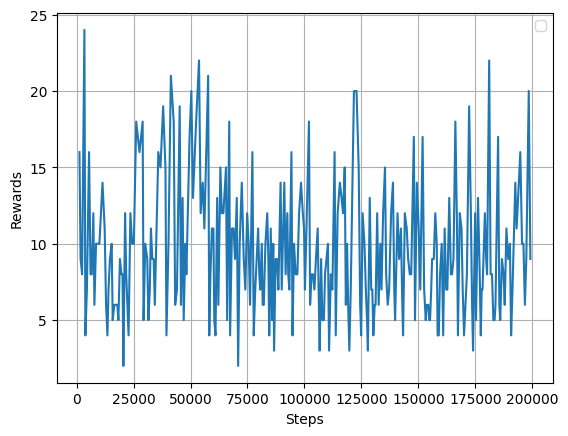

In [7]:
# Obtener las métricas
rewards = history.history['episode_reward']
steps = history.history['nb_steps']

# Crear el gráfico
plt.plot(steps, rewards)
plt.xlabel('Steps')
plt.ylabel('Rewards')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
#Evaluación en modo test
scores = dqn.test(env, nb_episodes=20, visualize=False)
print("Media de recompensa:", np.mean(scores.history['episode_reward']))

Testing for 20 episodes ...
Episode 1: reward: 18.000, steps: 727
Episode 2: reward: 18.000, steps: 713
Episode 3: reward: 18.000, steps: 715
Episode 4: reward: 18.000, steps: 718
Episode 5: reward: 18.000, steps: 708
Episode 6: reward: 18.000, steps: 727
Episode 7: reward: 18.000, steps: 720
Episode 8: reward: 18.000, steps: 726
Episode 9: reward: 18.000, steps: 721
Episode 10: reward: 18.000, steps: 715
Episode 11: reward: 18.000, steps: 714
Episode 12: reward: 18.000, steps: 701
Episode 13: reward: 18.000, steps: 722
Episode 14: reward: 18.000, steps: 723
Episode 15: reward: 18.000, steps: 715
Episode 16: reward: 18.000, steps: 727
Episode 17: reward: 18.000, steps: 721
Episode 18: reward: 18.000, steps: 720
Episode 19: reward: 18.000, steps: 716
Episode 20: reward: 18.000, steps: 719
Media de recompensa: 18.0


##### Guardado de pesos
dqn.save_weights('dqn_spaceinvaders_weights.h5f', overwrite=True)

3. Justificación de los parámetros seleccionados y de los resultados obtenidos

---